Test reading in multiple HSC files, try to make color color diagram
HSC data available at /datasets/hsc/repo/rerun/DM-13666/* where * = UDEEP, DEEP, or WIDE
see some documentation at 
https://confluence.lsstcorp.org/display/DM/S18+HSC+PDR1+reprocessing


In [1]:
import lsst.daf.persistence as daf_persistence
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 8)
import pandas as pd
import glob

In [2]:
depth = 'DEEP'
butler = daf_persistence.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
bandlist = ['HSC-G','HSC-R','HSC-I','HSC-Z','HSC-Y']
bandpaths = []
for band in bandlist:
    infile = glob.glob('/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/%s/10054/0,0/forced_src*'%(band))
    print (infile)
    bandpaths.append(infile)

['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-G/10054/0,0/forced_src-HSC-G-10054-0,0.fits']
['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-R/10054/0,0/forced_src-HSC-R-10054-0,0.fits']
['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-I/10054/0,0/forced_src-HSC-I-10054-0,0.fits']
['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-Z/10054/0,0/forced_src-HSC-Z-10054-0,0.fits']
['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-Y/10054/0,0/forced_src-HSC-Y-10054-0,0.fits']


In [4]:
print (len(bandpaths))

5


In [10]:
tract = 10054
patch = '0,0'
band = 'HSC-I'

In [11]:
files = glob.glob('/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/%s/10054/*/'%(band))
patches = []
for x in files:
    patches.append(x[-4:-1])
print (patches)


['3,0', '0,4', '0,0', '4,1', '5,2', '2,0', '3,1', '4,2', '5,3', '1,0', '2,1', '3,2', '4,3', '1,1', '2,2', '3,3', '0,1', '1,2', '2,3', '3,4', '0,2', '1,3', '5,0', '2,4', '0,3', '4,0', '1,4', '5,1']


In [12]:
#help (butler)

select in i-band in terms of good flags?  Or should we do an intersection of good in all bands?

In [24]:
sources = butler.get('deepCoadd_forced_src', tract=tract, patch=patch, filter=band)
src_refs = butler.get('deepCoadd_ref',tract=tract,patch=patch,filter=band)
src_calib = butler.get('deepCoadd_calexp_calib',tract=tract,patch=patch,filter=band)
selection_catalog = src_refs['detect_isPrimary'] \
    & ~sources['base_SdssCentroid_flag'] \
    & ~sources['base_PixelFlags_flag_interpolated'] \
    & ~sources['base_PixelFlags_flag_saturated'] \
    & ~sources['base_PsfFlux_flag'] \
    & ~sources['modelfit_CModel_flag'] 
        

In [25]:
print (selection_catalog)

[False False False ... False False False]


In [46]:
patches = ('0,0','3,0')

In [58]:
flagfilter = 'HSC-I' #the filter which the "good" flags are set in
df_hsc = 'Null'
df_patchtmp = 'Null'
for band in bandlist:
    df_patch = 'Null'
    for patch in patches:
        psfname = "%s_psf"%(band[4])
        cmname = "%s_cm"%(band[4])
        sources = butler.get('deepCoadd_forced_src', tract=tract, patch=patch, filter=band)
        src_refs = butler.get('deepCoadd_ref',tract=tract,patch=patch,filter=band)
        src_calib = butler.get('deepCoadd_calexp_calib',tract=tract,patch=patch,filter=band)
        src_calib.setThrowOnNegativeFlux(False)
        flagrefs = butler.get('deepCoadd_ref',tract=tract,patch=patch,filter=flagfilter)
        flag_sources = butler.get('deepCoadd_forced_src', tract=tract, patch=patch, filter=flagfilter)
        selection_catalog = flagrefs['detect_isPrimary'] \
            & ~flag_sources['base_SdssCentroid_flag'] \
            & ~flag_sources['base_PixelFlags_flag_interpolated'] \
            & ~flag_sources['base_PixelFlags_flag_saturated'] \
            & ~flag_sources['base_PsfFlux_flag'] \
            & ~flag_sources['modelfit_CModel_flag'] 
        print (sum(selection_catalog))
        psf_mag_tup = src_calib.getMagnitude(sources['base_PsfFlux_flux'],sources['base_PsfFlux_fluxSigma'])
        #print (psf_mag)
        cmodel_tup =  src_calib.getMagnitude(sources['modelfit_CModel_flux'],sources['modelfit_CModel_fluxSigma'])
        #print (len(cmodel))
        #cm_mag = coadd_calib.getMagnitude(coadd_forced_src['modelfit_CModel_flux'])
        psfmag = psf_mag_tup[0]
        psfmagerr = psf_mag_tup[1]
        cmodel = cmodel_tup[0]
        cmodelerr = cmodel_tup[1]
        if band == bandlist[-1]:
            extend = sources.get('base_ClassificationExtendedness_value')[selection_catalog]
            data = {'%s_psf'%(band[4]): psfmag[selection_catalog], '%s_psferr'%(band[4]): psfmagerr[selection_catalog], 
            '%s_cm'%(band[4]): cmodel[selection_catalog], '%s_cmerr'%(band[4]):cmodelerr[selection_catalog], 'extended': extend}
        else:
            data = {'%s_psf'%(band[4]): psfmag[selection_catalog], '%s_psferr'%(band[4]): psfmagerr[selection_catalog], 
            '%s_cm'%(band[4]): cmodel[selection_catalog], '%s_cmerr'%(band[4]):cmodelerr[selection_catalog]}
        if df_patch is 'Null':            
            df_patch = pd.DataFrame(data=data)
            print (df_patch.shape)
        else:
            df_patchtmp = pd.DataFrame(data=data)
            df_patch = pd.concat([df_patch,df_patchtmp])
            del df_patchtmp
            #pd.concat(df_hsc,df_tmp, axis=1)
            #pd.merge(df_hsc, df_tmp, left_index=True, right_index=True, how='outer')
            print (df_patch.shape)
    if df_hsc is 'Null':
        df_hsc = df_patch
    else: 
        df_hsc = pd.concat([df_hsc, df_patch], axis=1)
        del df_patch

3241
(3241, 4)
6404
(9645, 4)
3241
(3241, 4)
6404
(9645, 4)
3241
(3241, 4)
6404
(9645, 4)
3241
(3241, 4)
6404
(9645, 4)
3241
(3241, 5)
6404
(9645, 5)


In [59]:
#help (src_calib)
df_hsc.head()

,G_cm,G_cmerr,G_psf,G_psferr,R_cm,R_cmerr,R_psf,R_psferr,I_cm,I_cmerr,...,I_psferr,Z_cm,Z_cmerr,Z_psf,Z_psferr,Y_cm,Y_cmerr,Y_psf,Y_psferr,extended
0,26.287338,0.177019,26.301566,0.170576,27.054852,0.237404,27.080932,0.230363,26.463142,0.189496,...,0.188553,26.513584,0.279609,26.518350,0.267580,32.380179,353.267495,29.039245,15.269784,0.0
1,26.904710,0.326264,26.955138,0.302751,26.554410,0.162769,26.686038,0.162281,26.021823,0.123827,...,0.121875,26.070601,0.180097,26.225362,0.182874,26.014082,0.825525,26.027107,0.749855,0.0
2,25.479945,0.102677,25.716111,0.102201,25.261532,0.055465,25.567551,0.058570,24.511353,0.033327,...,0.034626,24.244836,0.037218,24.535676,0.038634,24.084351,0.159654,24.396312,0.172419,1.0
3,NaN,NaN,30.381380,7.765195,26.837579,0.231156,27.078802,0.235063,26.528164,0.227182,...,0.234506,25.987587,0.194160,26.208106,0.198548,27.284600,3.648553,26.794657,1.936741,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.652816,0.192323,...,0.191856,26.660164,0.284955,26.684915,0.282361,25.320410,0.425001,25.348028,0.421236,1.0


In [16]:
extend = sources.get('base_ClassificationExtendedness_value')[selection_catalog]
print (len(extend))
data = {'extended': extend}
df_tmp = pd.DataFrame(data = data)
df_hsc = pd.concat([df_hsc,df_tmp],axis=1)
del df_tmp

3241


In [52]:
print (len(df_hsc['G_psf']))
df_hsc.head()


9645


,G_cm,G_cmerr,G_psf,G_psferr,R_cm,R_cmerr,R_psf,R_psferr,I_cm,I_cmerr,I_psf,I_psferr,Z_cm,Z_cmerr,Z_psf,Z_psferr,Y_cm,Y_cmerr,Y_psf,Y_psferr
0,26.287338,0.177019,26.301566,0.170576,27.054852,0.237404,27.080932,0.230363,26.463142,0.189496,26.547614,0.188553,26.513584,0.279609,26.518350,0.267580,32.380179,353.267495,29.039245,15.269784
1,26.904710,0.326264,26.955138,0.302751,26.554410,0.162769,26.686038,0.162281,26.021823,0.123827,26.197510,0.121875,26.070601,0.180097,26.225362,0.182874,26.014082,0.825525,26.027107,0.749855
2,25.479945,0.102677,25.716111,0.102201,25.261532,0.055465,25.567551,0.058570,24.511353,0.033327,24.817668,0.034626,24.244836,0.037218,24.535676,0.038634,24.084351,0.159654,24.396312,0.172419
3,NaN,NaN,30.381380,7.765195,26.837579,0.231156,27.078802,0.235063,26.528164,0.227182,26.788772,0.234506,25.987587,0.194160,26.208106,0.198548,27.284600,3.648553,26.794657,1.936741
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.652816,0.192323,26.679153,0.191856,26.660164,0.284955,26.684915,0.282361,25.320410,0.425001,25.348028,0.421236


In [53]:
df_hsc.tail()

,G_cm,G_cmerr,G_psf,G_psferr,R_cm,R_cmerr,R_psf,R_psferr,I_cm,I_cmerr,I_psf,I_psferr,Z_cm,Z_cmerr,Z_psf,Z_psferr,Y_cm,Y_cmerr,Y_psf,Y_psferr
6399,27.526446,1.047878,27.908376,0.997417,31.700155,41.810114,NaN,NaN,27.068691,0.682020,27.826637,0.723476,27.882220,2.134977,28.608539,2.245996,26.464239,3.572747,28.620833,15.156615
6400,NaN,NaN,NaN,NaN,27.517088,0.612360,27.832812,0.642075,28.052037,1.039497,28.173566,0.986319,27.605802,1.077025,27.616878,0.939492,26.593642,2.843830,26.355827,2.016612
6401,26.852517,0.385496,26.968695,0.417271,28.457935,1.145689,28.494695,1.181720,27.354259,0.473106,27.375817,0.481368,28.749559,2.657101,29.576075,5.684453,25.797322,1.164365,25.883571,1.252741
6402,28.883546,2.373172,29.537600,3.902252,27.910265,0.609586,27.900338,0.600880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.863411,35.384710,26.970012,0.975656,27.809062,1.356457,NaN,NaN,NaN,NaN


(0, 3)

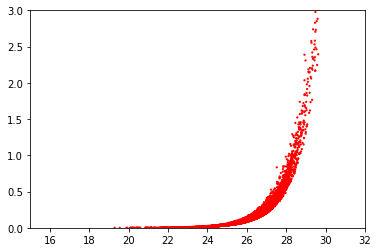

In [55]:
plt.scatter(df_hsc['R_psf'],df_hsc['R_psferr'],s=5,c='r',edgecolor='None')
plt.xlim([15,32])
plt.ylim([0,3])

In [56]:
gr = df_hsc['G_psf'] - df_hsc['R_psf']
ri = df_hsc['R_psf'] - df_hsc['I_psf']
mask = (df_hsc['I_psferr']<.1)
grcut = gr[mask]
ricut = ri[mask]

(-4, 4)

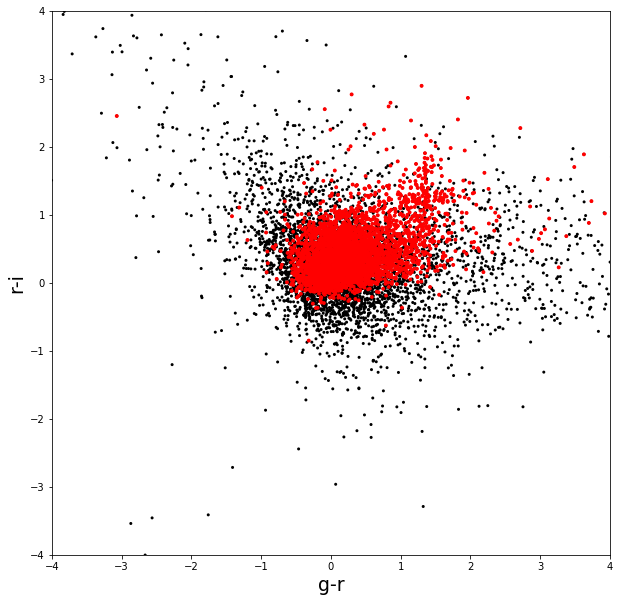

In [57]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.scatter(gr,ri,marker='o',s=9,c='k',edgecolor='none')
plt.scatter(grcut,ricut,marker='o',s=15,c='r',edgecolor='none')
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)
plt.xlim([-4,4])
plt.ylim([-4,4])

In [24]:
grmod = df_hsc['G_cm'] - df_hsc['R_cm']
rimod = df_hsc['R_cm'] - df_hsc['I_cm']
maskmod = (df_hsc['I_cm']<25.)
grmodcut = gr[maskmod]
rimodcut = ri[maskmod]
print (len(grmod),len(rimod),len(grmodcut),len(df_hsc['G_cm']))

3241 3241 974 3241


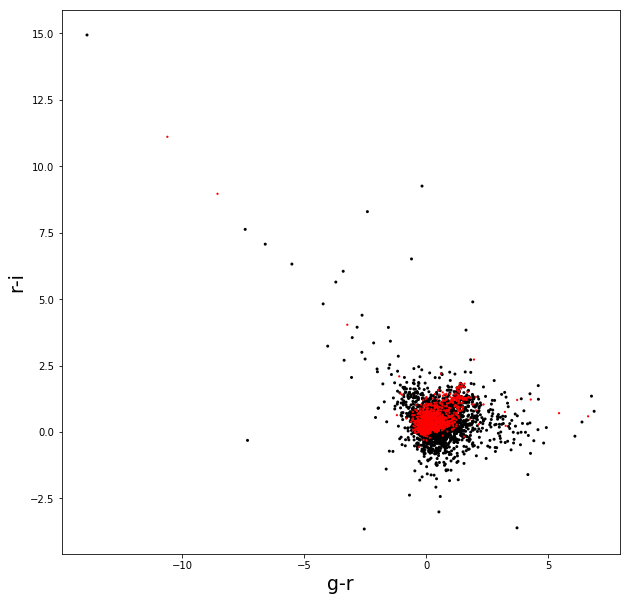

In [25]:
plt.scatter(grmod,rimod,marker='o',s=9,c='k',edgecolor='none')
plt.scatter(grmodcut,rimodcut,marker='o',s=5,c='r',edgecolor='none')
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)



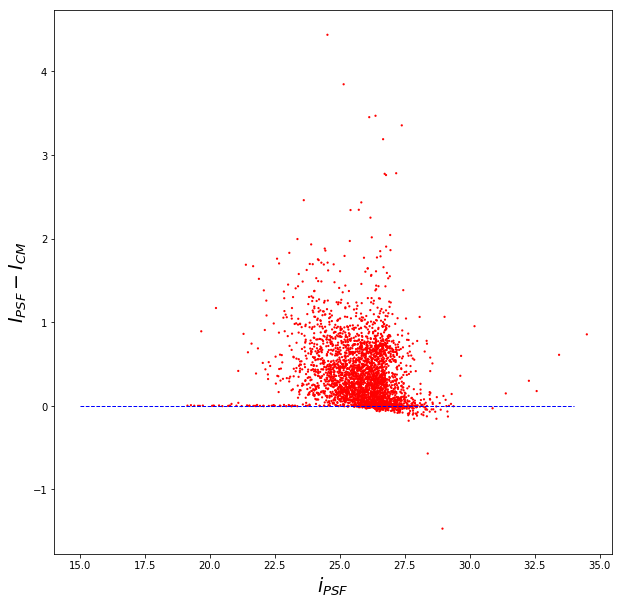

In [26]:
deli = df_hsc['I_psf']-df_hsc['I_cm']
extendedness = df_hsc['extended']
plt.scatter(df_hsc['I_psf'],deli,marker='o',s=5,c='r',edgecolor='none')
plt.plot([15,34],[0,0],linewidth=1,linestyle='--',color='b')
plt.xlabel("$i_{PSF}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CM}$",fontsize=19)

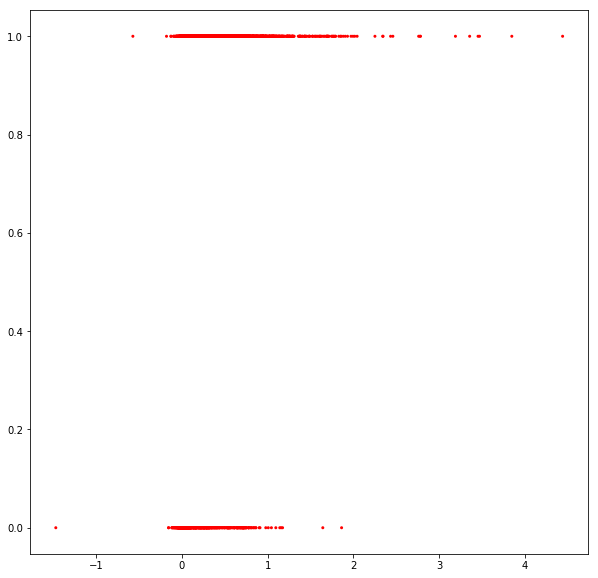

In [27]:
plt.scatter(deli,extendedness,marker='o',s=9,edgecolor='None',c='r')

(-1, 3)

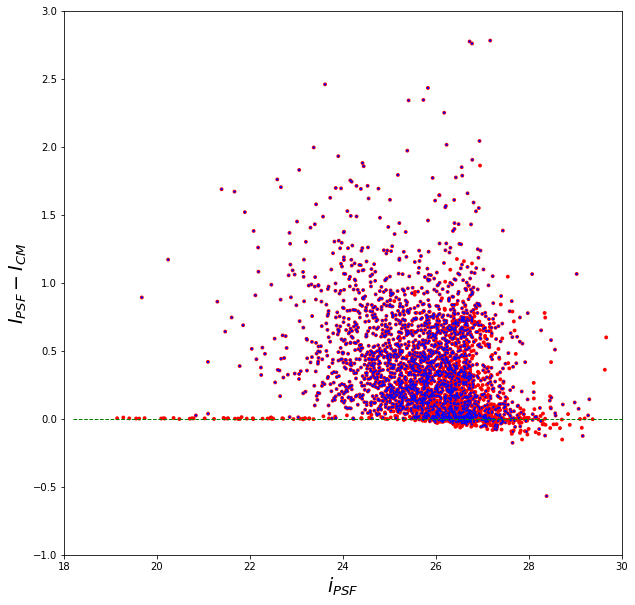

In [28]:
extflag = np.where(extendedness>.4)[0]
plt.scatter(df_hsc['I_psf'],deli,marker='o',s=15,c='r',edgecolor='none')
plt.scatter(df_hsc['I_psf'][extflag],deli[extflag],marker='o',s=5,c='b',edgecolor='None')
plt.plot([18.2,30],[0,0],linewidth=1,linestyle='--',color='g')
plt.xlabel("$i_{PSF}$",fontsize=19)
plt.ylabel("$I_{PSF}-I_{CM}$",fontsize=19)
plt.xlim([18,30])
plt.ylim([-1,3])

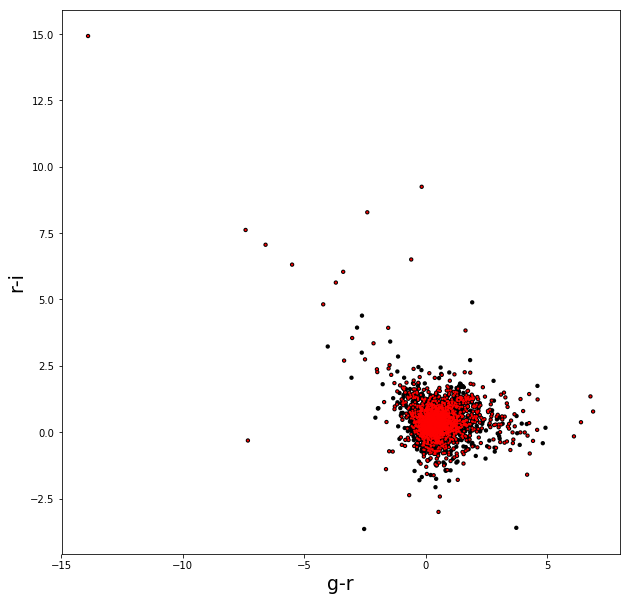

In [29]:
plt.scatter(grmod,rimod,marker='o',s=19,c='k',edgecolor='none')
plt.scatter(grmod[extflag],rimod[extflag],marker='o',s=5,c='r',edgecolor='none')
plt.xlabel("g-r",fontsize=19)
plt.ylabel("r-i",fontsize=19)

In [40]:
bandlist = ['HSC-G']
xbandpaths = []
for band in bandlist:
    infile = glob.glob('/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/%s/10054/*/forced_src*'%(band))
    print (infile)
    xbandpaths.append(infile)

['/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-G/10054/3,0/forced_src-HSC-G-10054-3,0.fits', '/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-G/10054/0,4/forced_src-HSC-G-10054-0,4.fits', '/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-G/10054/0,0/forced_src-HSC-G-10054-0,0.fits', '/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-G/10054/4,1/forced_src-HSC-G-10054-4,1.fits', '/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-G/10054/5,2/forced_src-HSC-G-10054-5,2.fits', '/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-G/10054/2,0/forced_src-HSC-G-10054-2,0.fits', '/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-G/10054/3,1/forced_src-HSC-G-10054-3,1.fits', '/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-G/10054/4,2/forced_src-HSC-G-10054-4,2.fits', '/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-G/10054/5,3/forced_src-HSC-G-10054-5,3.fits', '/datasets/hsc/repo/rerun/D